Wenhao Li 1004005854

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math
import scipy.stats as scs
import matplotlib.pyplot as plt

In [2]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)


print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


# Out-of-sample

In [3]:
filename_save_out = 'scen_out'
if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    # Generating Scenarios
    num_cd = np.shape(sqrt_rho)[0] # number of credict drivers
    y = np.zeros((Nout, num_cd)) # empty array for credit driver
    w = np.zeros((Nout, K)) # empty array for creditworthiness insex
    Losses_out = np.zeros((Nout, K))
    
    for s in range(1, Nout + 1):
        
        # random normal distribution
        rand_factor = np.random.normal(0,1,num_cd)
        y[s-1,:] = np.dot(sqrt_rho, rand_factor)
        
        # idiosyncratic factor, normal distribution with mean 0 and variation 1
        z = np.random.normal(0,1,K)
        
        # compute w, creditworthiness
        for k in range (1,K+1):
            # w_j = beta_j * y_j + sigma_j_k * z_j
            cp_driver = int(driver[k-1]) # the credit driver for the counterparty
            w[s-1, k-1] = beta[k-1] * y[s-1,cp_driver-1] + np.sqrt(1 - (beta[k-1])**2) * z[k-1]
            
            # place where the creditworthiness is, in credit-state boundaries
            new_place_credit_state = np.sort(np.append(w[s-1, k-1], CS_Bdry[k-1,:]))
            # convert to list so that can use function index to find index of w[s-1, k-1]
            new_place_credit_state = list(new_place_credit_state)
            indicator = new_place_credit_state.index(w[s-1, k-1])
            

            Losses_out[s-1, k-1] = exposure[k-1,indicator]

    # Calculated out-of-sample losses (100000 x 100)
    # Losses_out (sparse matrix)
    Losses_out = scipy.sparse.csc_matrix(Losses_out)

In [4]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out.toarray(), rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #
        # loss = np.sort(np.dot(Losses_out, x0[portN]))
        loss = np.sort(Losses_out@x0[portN])
        VaRout[portN, q] = loss[int(math.ceil(Nout * alf)) - 1]
        VaRinN[portN, q] = np.mean(loss) + scs.norm.ppf(alf) * np.std(loss)
        CVaRout[portN, q] =  (1 / (Nout * (1 - alf))) * ((math.ceil(Nout * alf) - Nout * alf) * VaRout[portN, q] + sum(loss[int(math.ceil(Nout * alf)):]))
        CVaRinN[portN, q] = np.mean(loss) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(loss)


# In-sample

In [5]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)
        
        
for tr in range(1, N_trials + 1):
    
    # Monte Carlo approximation 1
    y_inMC1 = np.zeros((int(np.ceil(Nin / Ns)), num_cd))
    w_inMC1 = np.zeros((Nin,K))
    Losses_inMC1 = np.zeros((Nin,K)) # (5000,100)
    
    for s in range(1, np.int32(np.ceil(Nin / Ns) + 1)): # systemic scenarios, 1000
        # random normal distribution
        rand_factor = np.random.normal(0,1,num_cd)
        y_inMC1[s-1,:] = np.dot(sqrt_rho, rand_factor)
        
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic, 5
            z_inMC1 = np.random.normal(0,1,K)

            # Calculate losses for MC1 approximation (5000 x 100)
            # Losses_inMC1
            for k in range (1,K+1): # 100
                # w_j = beta_j * y_j + sigma_j_k * z_j
                cp_driver = int(driver[k-1]) # the credit driver for the counterparty
                w_inMC1[5*(s-1)+(si-1), k-1] = beta[k-1] * y_inMC1[s-1,cp_driver-1] + np.sqrt(1 - (beta[k-1])**2) * z_inMC1[k-1]
                
                # place where the creditworthiness is, in credit-state boundaries
                new_place_credit_state = np.sort(np.append(w_inMC1[5*(s-1)+(si-1), k-1], CS_Bdry[k-1,:]))
                # convert to list so that can use function index to find index of w[s-1, k-1]
                new_place_credit_state = list(new_place_credit_state)
                indicator = new_place_credit_state.index(w_inMC1[5*(s-1)+(si-1), k-1])
                
                Losses_inMC1[5*(s-1)+(si-1), k-1] = exposure[k-1,indicator]
   



    # Monte Carlo approximation 2
    y_inMC2 = np.zeros((Nin, num_cd))
    w_inMC2 = np.zeros((Nin, K))
    Losses_inMC2 = np.zeros((Nin,K)) # (5000,100)
    
    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # random normal distribution
        rand_factor = np.random.normal(0,1,num_cd)
        y_inMC2[s-1,:] = np.dot(sqrt_rho, rand_factor)
        z_inMC2 = np.random.normal(0,1,K)
        
    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2
        for k in range (1,K+1):
            # w_j = beta_j * y_j + sigma_j_k * z_j
            cp_driver = int(driver[k-1]) # the credit driver for the counterparty
            w_inMC2[s-1, k-1] = beta[k-1] * y_inMC2[s-1,cp_driver-1] + np.sqrt(1 - (beta[k-1])**2) * z_inMC2[k-1]
                
            # place where the creditworthiness is, in credit-state boundaries
            new_place_credit_state = np.sort(np.append(w_inMC2[s-1, k-1], CS_Bdry[k-1,:]))
            # convert to list so that can use function index to find index of w[s-1, k-1]
            new_place_credit_state = list(new_place_credit_state)
            indicator = new_place_credit_state.index(w_inMC2[s-1, k-1])
                
            Losses_inMC2[s-1, k-1] = exposure[k-1,indicator]

            

    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = np.sort(np.dot(Losses_inMC1, x0[portN]))
            portf_loss_inMC2 = np.sort(np.dot(Losses_inMC2, x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.mean(portf_loss_inMC1)
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            mu_p_MC2 = np.mean(portf_loss_inMC2)
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) - 1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) - 1]
            
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2
            
            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC1[portN, q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin * alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC2[portN, q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin * alf)):]))
            
            CVaRinN1[portN, q][tr - 1] =  mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] =  mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC2


In [6]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $37224279.60, CVaR 99.0% = $44700209.98
In-sample MC1: VaR 99.0% = $36923585.73, CVaR 99.0% = $44397752.66
In-sample MC2: VaR 99.0% = $37335232.57, CVaR 99.0% = $44874637.61
In-sample No: VaR 99.0% = $26231163.64, CVaR 99.0% = $29125693.96
In-sample N1: VaR 99.0% = $26143547.56, CVaR 99.0% = $29025723.51
In-sample N2: VaR 99.0% = $26284755.06, CVaR 99.0% = $29184999.54

Out-of-sample: VaR 99.9% = $54009147.56, CVaR 99.9% = $60975475.86
In-sample MC1: VaR 99.9% = $53424523.54, CVaR 99.9% = $61055433.08
In-sample MC2: VaR 99.9% = $53934526.62, CVaR 99.9% = $61696819.04
In-sample No: VaR 99.9% = $32756115.65, CVaR 99.9% = $35120980.79
In-sample N1: VaR 99.9% = $32640649.93, CVaR 99.9% = $34995421.42
In-sample N2: VaR 99.9% = $32822588.15, CVaR 99.9% = $35192121.84


Portfolio 2:

Out-of-sample: VaR 99.0% = $27480823.68, CVaR 99.0% = $33424646.72
In-sample MC1: VaR 99.0% = $27213074.49, CVaR 99.0% = $32954475.00
In-sample MC2: VaR 99.0% = $27491016

# Plot Loss Distribution (6 plots, 2 portfolios & 3 scenarios)

## Portfolio 1

### Out-Of-Sample

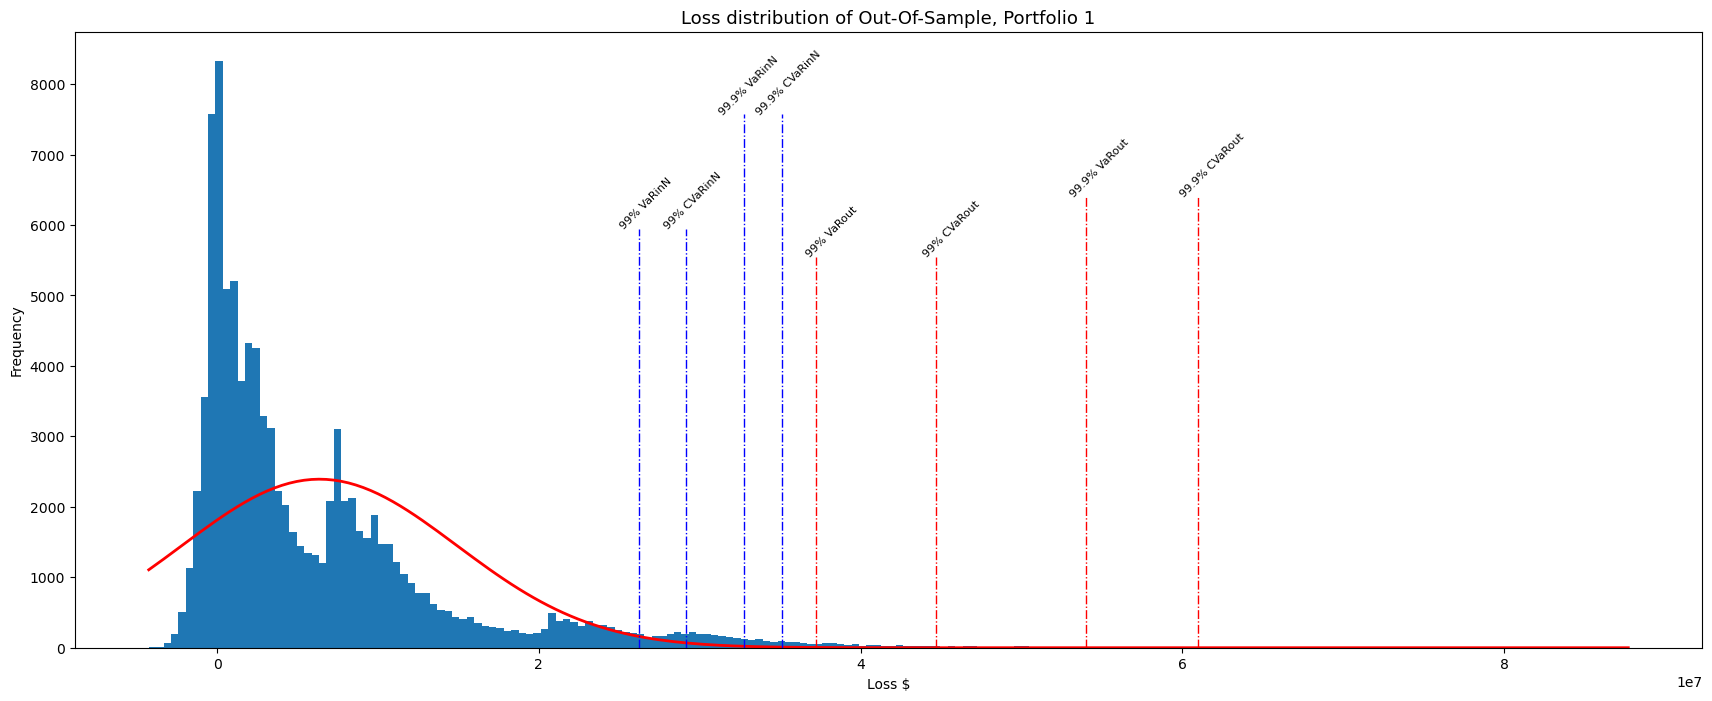

In [7]:
fig = plt.figure(figsize=(21,8))
frequencyCounts, binLocations, patches = plt.hist(Losses_out @ x0[0], 200)
# Plot the Normal curve 
sigma = np.std(Losses_out @ x0[0])
mu = np.mean(Losses_out @ x0[0])
normf = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (binLocations - mu)**2 / (2 * sigma**2))
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, linewidth=2, color='r')

# VaR
plt.plot([VaRout[0,0],VaRout[0,0]], [0,max(frequencyCounts)/1.5], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * VaRout[0,0], max(frequencyCounts)/1.5, '99% VaRout',fontsize=8, rotation=45)
plt.plot([VaRout[0,1],VaRout[0,1]], [0,max(frequencyCounts)/1.3], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * VaRout[0,1], max(frequencyCounts)/1.3, '99.9% VaRout',fontsize=8, rotation=45)
plt.plot([CVaRout[0,0],CVaRout[0,0]], [0,max(frequencyCounts)/1.5], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * CVaRout[0,0], max(frequencyCounts)/1.5, '99% CVaRout',fontsize=8, rotation=45)
plt.plot([CVaRout[0,1],CVaRout[0,1]], [0,max(frequencyCounts)/1.3], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * CVaRout[0,1], max(frequencyCounts)/1.3, '99.9% CVaRout',fontsize=8, rotation=45)


# VaRinN
plt.plot([VaRinN[0,0],VaRinN[0,0]], [0,max(frequencyCounts)/1.4], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * VaRinN[0,0], max(frequencyCounts)/1.4, '99% VaRinN',fontsize=8, rotation=45)
plt.plot([VaRinN[0,1],VaRinN[0,1]], [0,max(frequencyCounts)/1.1], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * VaRinN[0,1], max(frequencyCounts)/1.1, '99.9% VaRinN',fontsize=8, rotation=45)
plt.plot([CVaRinN[0,0],CVaRinN[0,0]], [0,max(frequencyCounts)/1.4], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * CVaRinN[0,0], max(frequencyCounts)/1.4, '99% CVaRinN',fontsize=8, rotation=45)
plt.plot([CVaRinN[0,1],CVaRinN[0,1]], [0,max(frequencyCounts)/1.1], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * CVaRinN[0,1], max(frequencyCounts)/1.1, '99.9% CVaRinN',fontsize=8, rotation=45)


plt.xlabel('Loss $')
plt.ylabel('Frequency')
plt.title('Loss distribution of Out-Of-Sample, Portfolio 1', fontsize=13)
plt.show()

### In-Sample, Monte Carlo 1

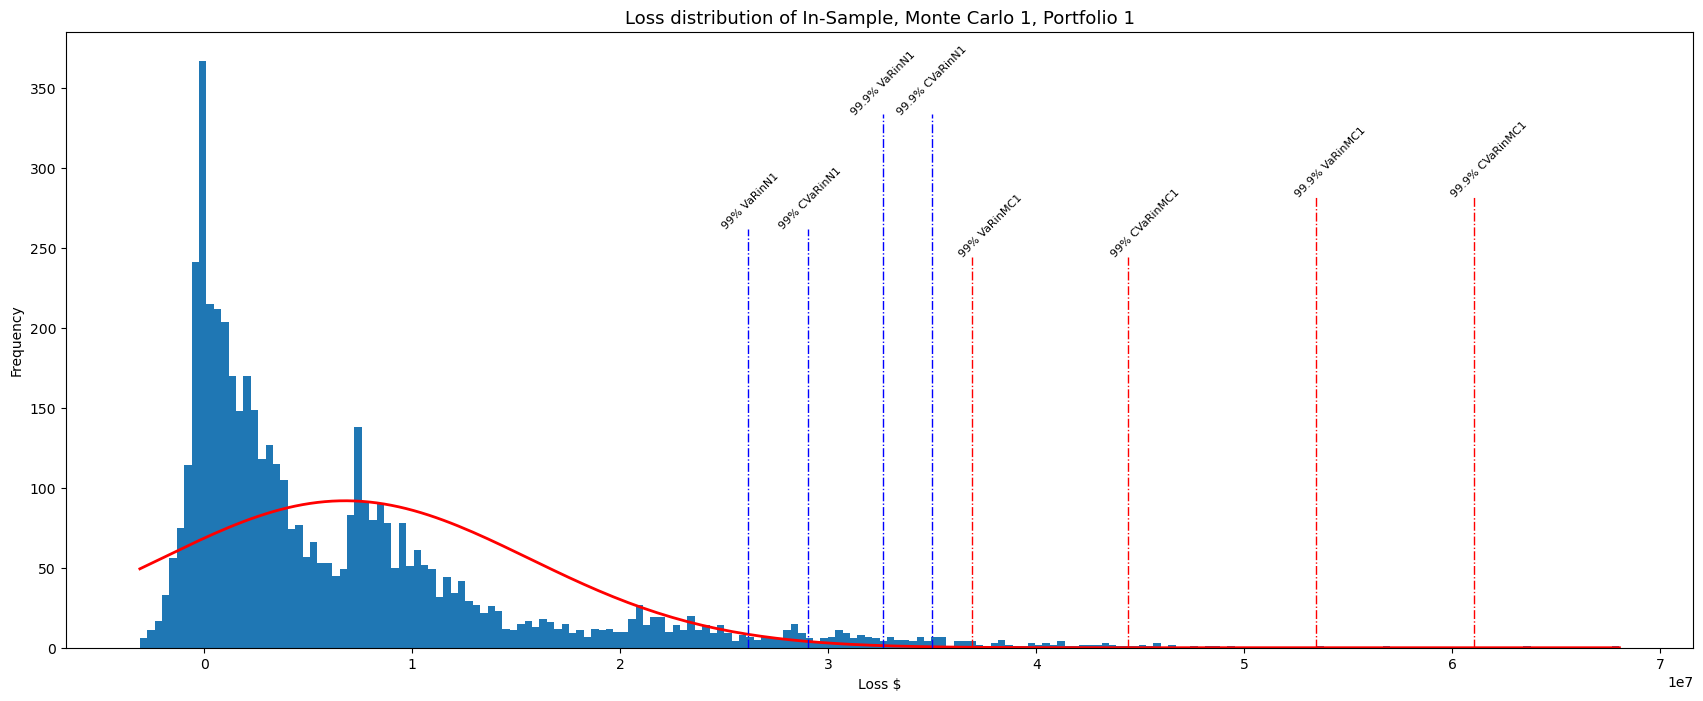

In [8]:
fig = plt.figure(figsize=(21,8))
frequencyCounts, binLocations, patches = plt.hist(Losses_inMC1 @ x0[0], 200)
# Plot the Normal curve 
sigma = np.std(np.dot(Losses_inMC1, x0[0]))
mu = np.mean(np.dot(Losses_inMC1, x0[0]))
normf = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (binLocations - mu)**2 / (2 * sigma**2))
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, linewidth=2, color='r')

# VaRinMC1
plt.plot([np.mean(VaRinMC1[0,0]),np.mean(VaRinMC1[0,0])], [0,max(frequencyCounts)/1.5], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(VaRinMC1[0,0]), max(frequencyCounts)/1.5, '99% VaRinMC1',fontsize=8, rotation=45)
plt.plot([np.mean(VaRinMC1[0,1]),np.mean(VaRinMC1[0,1])], [0,max(frequencyCounts)/1.3], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(VaRinMC1[0,1]), max(frequencyCounts)/1.3, '99.9% VaRinMC1',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinMC1[0,0]),np.mean(CVaRinMC1[0,0])], [0,max(frequencyCounts)/1.5], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(CVaRinMC1[0,0]), max(frequencyCounts)/1.5, '99% CVaRinMC1',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinMC1[0,1]),np.mean(CVaRinMC1[0,1])], [0,max(frequencyCounts)/1.3], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(CVaRinMC1[0,1]), max(frequencyCounts)/1.3, '99.9% CVaRinMC1',fontsize=8, rotation=45)


# VaRinN1
plt.plot([np.mean(VaRinN1[0,0]),np.mean(VaRinN1[0,0])], [0,max(frequencyCounts)/1.4], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(VaRinN1[0,0]), max(frequencyCounts)/1.4, '99% VaRinN1',fontsize=8, rotation=45)
plt.plot([np.mean(VaRinN1[0,1]),np.mean(VaRinN1[0,1])], [0,max(frequencyCounts)/1.1], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(VaRinN1[0,1]), max(frequencyCounts)/1.1, '99.9% VaRinN1',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinN1[0,0]),np.mean(CVaRinN1[0,0])], [0,max(frequencyCounts)/1.4], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(CVaRinN1[0,0]), max(frequencyCounts)/1.4, '99% CVaRinN1',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinN1[0,1]),np.mean(CVaRinN1[0,1])], [0,max(frequencyCounts)/1.1], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(CVaRinN1[0,1]), max(frequencyCounts)/1.1, '99.9% CVaRinN1',fontsize=8, rotation=45)


plt.xlabel('Loss $')
plt.ylabel('Frequency')
plt.title('Loss distribution of In-Sample, Monte Carlo 1, Portfolio 1', fontsize=13)
plt.show()

### In-Sample, Monte Carlo 2

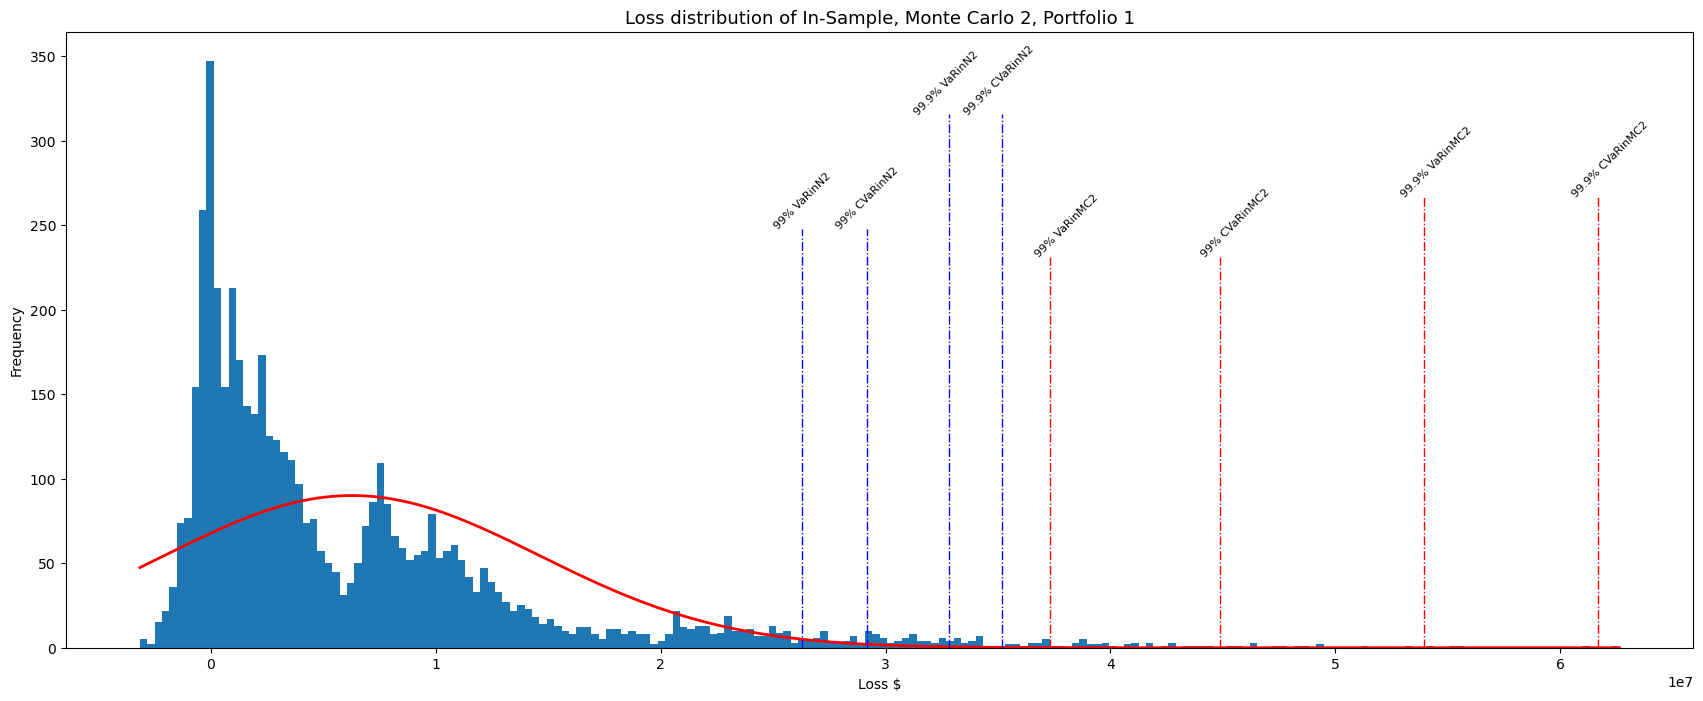

In [9]:
fig = plt.figure(figsize=(21,8))
frequencyCounts, binLocations, patches = plt.hist(Losses_inMC2 @ x0[0], 200)
# Plot the Normal curve 
sigma = np.std(np.dot(Losses_inMC2, x0[0]))
mu = np.mean(np.dot(Losses_inMC2, x0[0]))
normf = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (binLocations - mu)**2 / (2 * sigma**2))
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, linewidth=2, color='r')

# VaRinMC2
plt.plot([np.mean(VaRinMC2[0,0]),np.mean(VaRinMC2[0,0])], [0,max(frequencyCounts)/1.5], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(VaRinMC2[0,0]), max(frequencyCounts)/1.5, '99% VaRinMC2',fontsize=8, rotation=45)
plt.plot([np.mean(VaRinMC2[0,1]),np.mean(VaRinMC2[0,1])], [0,max(frequencyCounts)/1.3], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(VaRinMC2[0,1]), max(frequencyCounts)/1.3, '99.9% VaRinMC2',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinMC2[0,0]),np.mean(CVaRinMC2[0,0])], [0,max(frequencyCounts)/1.5], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(CVaRinMC2[0,0]), max(frequencyCounts)/1.5, '99% CVaRinMC2',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinMC2[0,1]),np.mean(CVaRinMC2[0,1])], [0,max(frequencyCounts)/1.3], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(CVaRinMC2[0,1]), max(frequencyCounts)/1.3, '99.9% CVaRinMC2',fontsize=8, rotation=45)


# VaRinN2
plt.plot([np.mean(VaRinN2[0,0]),np.mean(VaRinN2[0,0])], [0,max(frequencyCounts)/1.4], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(VaRinN2[0,0]), max(frequencyCounts)/1.4, '99% VaRinN2',fontsize=8, rotation=45)
plt.plot([np.mean(VaRinN2[0,1]),np.mean(VaRinN2[0,1])], [0,max(frequencyCounts)/1.1], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(VaRinN2[0,1]), max(frequencyCounts)/1.1, '99.9% VaRinN2',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinN2[0,0]),np.mean(CVaRinN2[0,0])], [0,max(frequencyCounts)/1.4], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(CVaRinN2[0,0]), max(frequencyCounts)/1.4, '99% CVaRinN2',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinN2[0,1]),np.mean(CVaRinN2[0,1])], [0,max(frequencyCounts)/1.1], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(CVaRinN2[0,1]), max(frequencyCounts)/1.1, '99.9% CVaRinN2',fontsize=8, rotation=45)


plt.xlabel('Loss $')
plt.ylabel('Frequency')
plt.title('Loss distribution of In-Sample, Monte Carlo 2, Portfolio 1', fontsize=13)
plt.show()

## Portfolio 2

### Out-Of-Sample

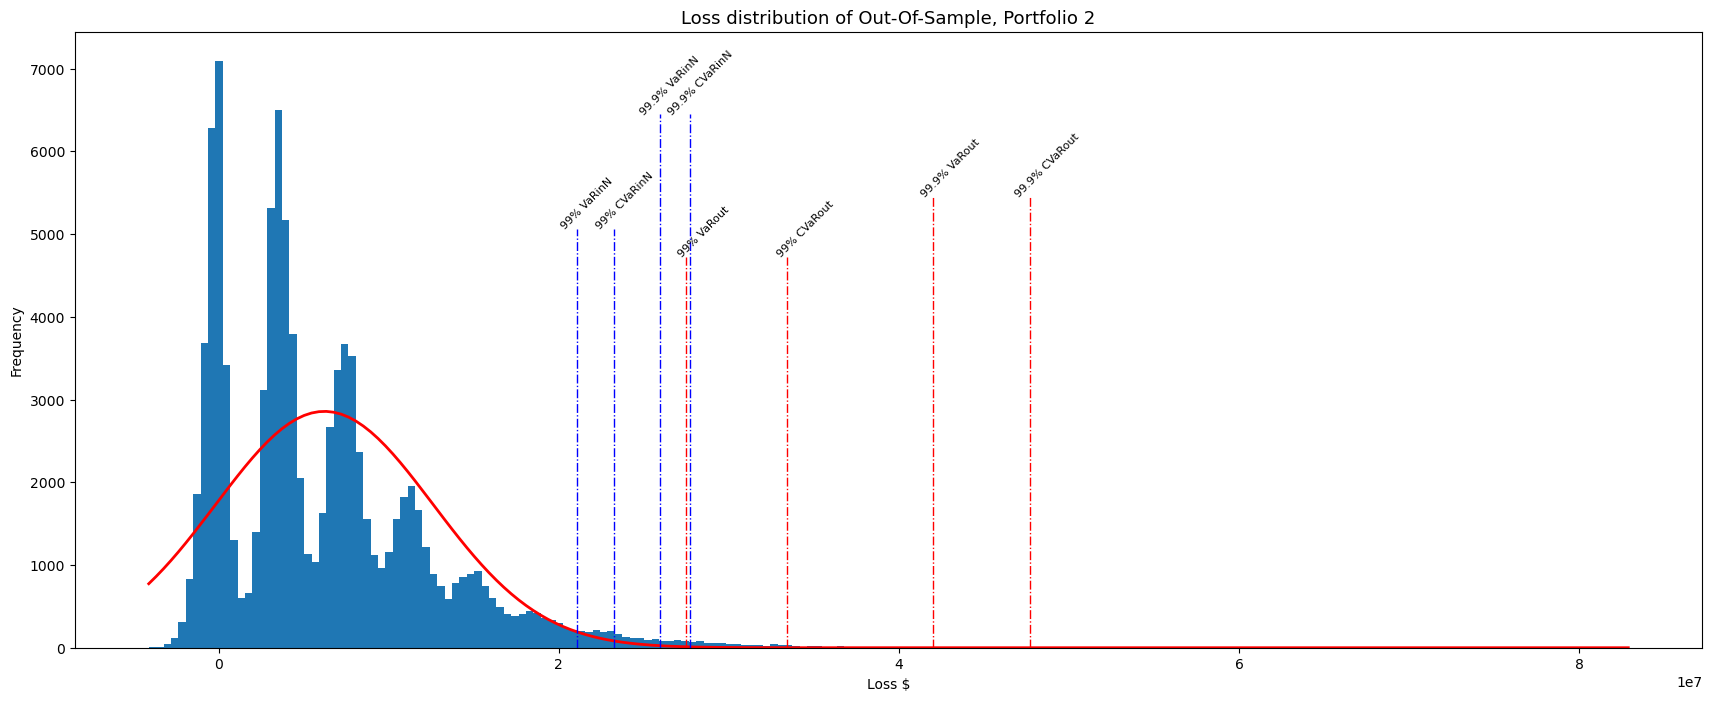

In [10]:
fig = plt.figure(figsize=(21,8))
frequencyCounts, binLocations, patches = plt.hist(Losses_out @ x0[1], 200)
# Plot the Normal curve 
sigma = np.std(Losses_out @ x0[1])
mu = np.mean(Losses_out @ x0[1])
normf = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (binLocations - mu)**2 / (2 * sigma**2))
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, linewidth=2, color='r')

# VaR
plt.plot([VaRout[1,0],VaRout[1,0]], [0,max(frequencyCounts)/1.5], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * VaRout[1,0], max(frequencyCounts)/1.5, '99% VaRout',fontsize=8, rotation=45)
plt.plot([VaRout[1,1],VaRout[1,1]], [0,max(frequencyCounts)/1.3], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * VaRout[1,1], max(frequencyCounts)/1.3, '99.9% VaRout',fontsize=8, rotation=45)
plt.plot([CVaRout[1,0],CVaRout[1,0]], [0,max(frequencyCounts)/1.5], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * CVaRout[1,0], max(frequencyCounts)/1.5, '99% CVaRout',fontsize=8, rotation=45)
plt.plot([CVaRout[1,1],CVaRout[1,1]], [0,max(frequencyCounts)/1.3], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * CVaRout[1,1], max(frequencyCounts)/1.3, '99.9% CVaRout',fontsize=8, rotation=45)


# VaRinN
plt.plot([VaRinN[1,0],VaRinN[1,0]], [0,max(frequencyCounts)/1.4], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * VaRinN[1,0], max(frequencyCounts)/1.4, '99% VaRinN',fontsize=8, rotation=45)
plt.plot([VaRinN[1,1],VaRinN[1,1]], [0,max(frequencyCounts)/1.1], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * VaRinN[1,1], max(frequencyCounts)/1.1, '99.9% VaRinN',fontsize=8, rotation=45)
plt.plot([CVaRinN[1,0],CVaRinN[1,0]], [0,max(frequencyCounts)/1.4], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * CVaRinN[1,0], max(frequencyCounts)/1.4, '99% CVaRinN',fontsize=8, rotation=45)
plt.plot([CVaRinN[1,1],CVaRinN[1,1]], [0,max(frequencyCounts)/1.1], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * CVaRinN[1,1], max(frequencyCounts)/1.1, '99.9% CVaRinN',fontsize=8, rotation=45)


plt.xlabel('Loss $')
plt.ylabel('Frequency')
plt.title('Loss distribution of Out-Of-Sample, Portfolio 2', fontsize=13)
plt.show()

### In-Sample, Monte Carlo 1

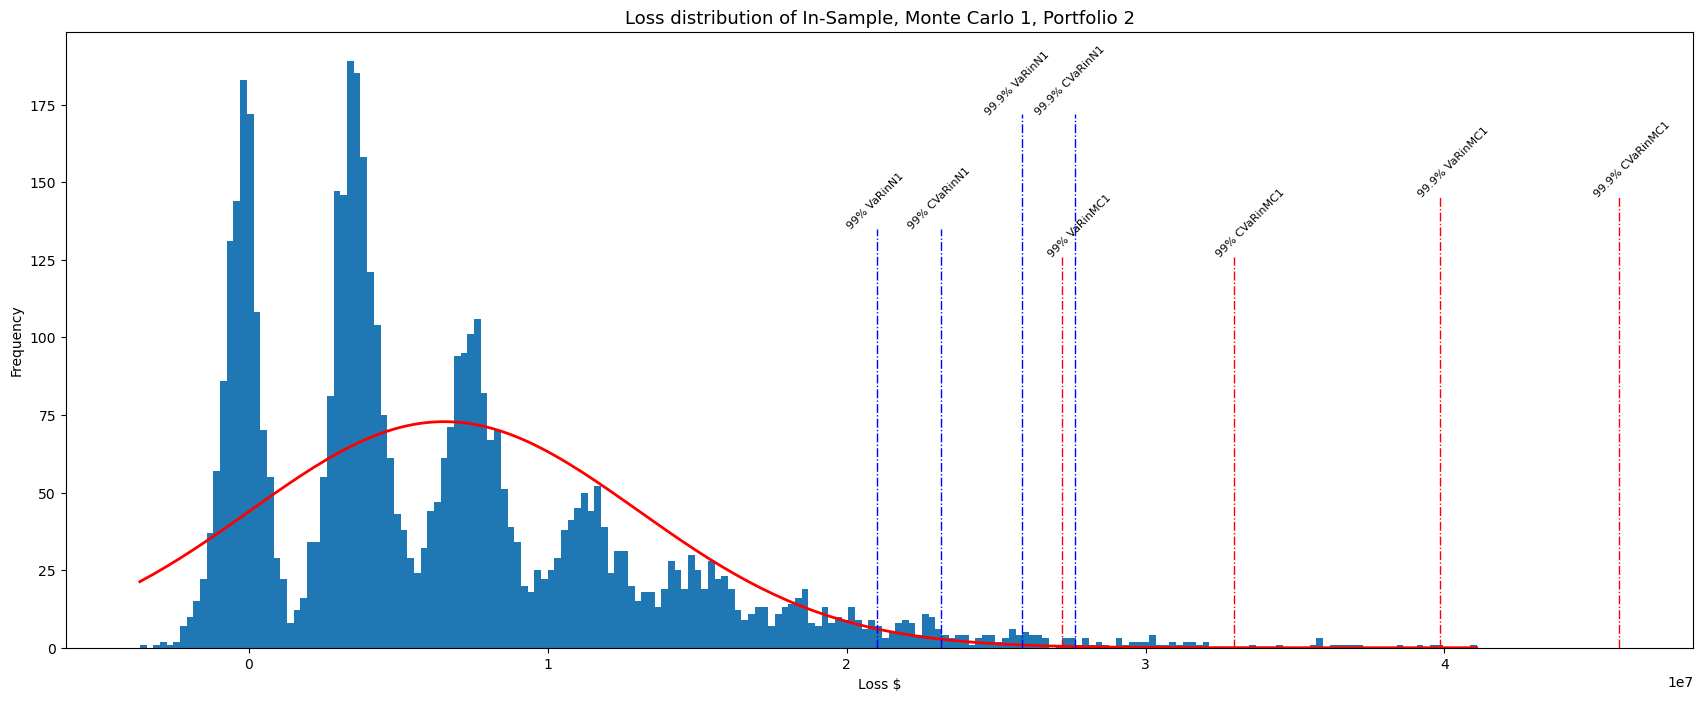

In [11]:
fig = plt.figure(figsize=(21,8))
frequencyCounts, binLocations, patches = plt.hist(Losses_inMC1 @ x0[1], 200)
# Plot the Normal curve 
sigma = np.std(np.dot(Losses_inMC1, x0[1]))
mu = np.mean(np.dot(Losses_inMC1, x0[1]))
normf = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (binLocations - mu)**2 / (2 * sigma**2))
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, linewidth=2, color='r')


# VaRinMC1
plt.plot([np.mean(VaRinMC1[1,0]),np.mean(VaRinMC1[1,0])], [0,max(frequencyCounts)/1.5], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(VaRinMC1[1,0]), max(frequencyCounts)/1.5, '99% VaRinMC1',fontsize=8, rotation=45)
plt.plot([np.mean(VaRinMC1[1,1]),np.mean(VaRinMC1[1,1])], [0,max(frequencyCounts)/1.3], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(VaRinMC1[1,1]), max(frequencyCounts)/1.3, '99.9% VaRinMC1',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinMC1[1,0]),np.mean(CVaRinMC1[1,0])], [0,max(frequencyCounts)/1.5], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(CVaRinMC1[1,0]), max(frequencyCounts)/1.5, '99% CVaRinMC1',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinMC1[1,1]),np.mean(CVaRinMC1[1,1])], [0,max(frequencyCounts)/1.3], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(CVaRinMC1[1,1]), max(frequencyCounts)/1.3, '99.9% CVaRinMC1',fontsize=8, rotation=45)


# VaRinN1
plt.plot([np.mean(VaRinN1[1,0]),np.mean(VaRinN1[1,0])], [0,max(frequencyCounts)/1.4], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(VaRinN1[1,0]), max(frequencyCounts)/1.4, '99% VaRinN1',fontsize=8, rotation=45)
plt.plot([np.mean(VaRinN1[1,1]),np.mean(VaRinN1[1,1])], [0,max(frequencyCounts)/1.1], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(VaRinN1[1,1]), max(frequencyCounts)/1.1, '99.9% VaRinN1',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinN1[1,0]),np.mean(CVaRinN1[1,0])], [0,max(frequencyCounts)/1.4], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(CVaRinN1[1,0]), max(frequencyCounts)/1.4, '99% CVaRinN1',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinN1[1,1]),np.mean(CVaRinN1[1,1])], [0,max(frequencyCounts)/1.1], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(CVaRinN1[1,1]), max(frequencyCounts)/1.1, '99.9% CVaRinN1',fontsize=8, rotation=45)


plt.xlabel('Loss $')
plt.ylabel('Frequency')
plt.title('Loss distribution of In-Sample, Monte Carlo 1, Portfolio 2', fontsize=13)
plt.show()

### In-Sample, Monte Carlo 2

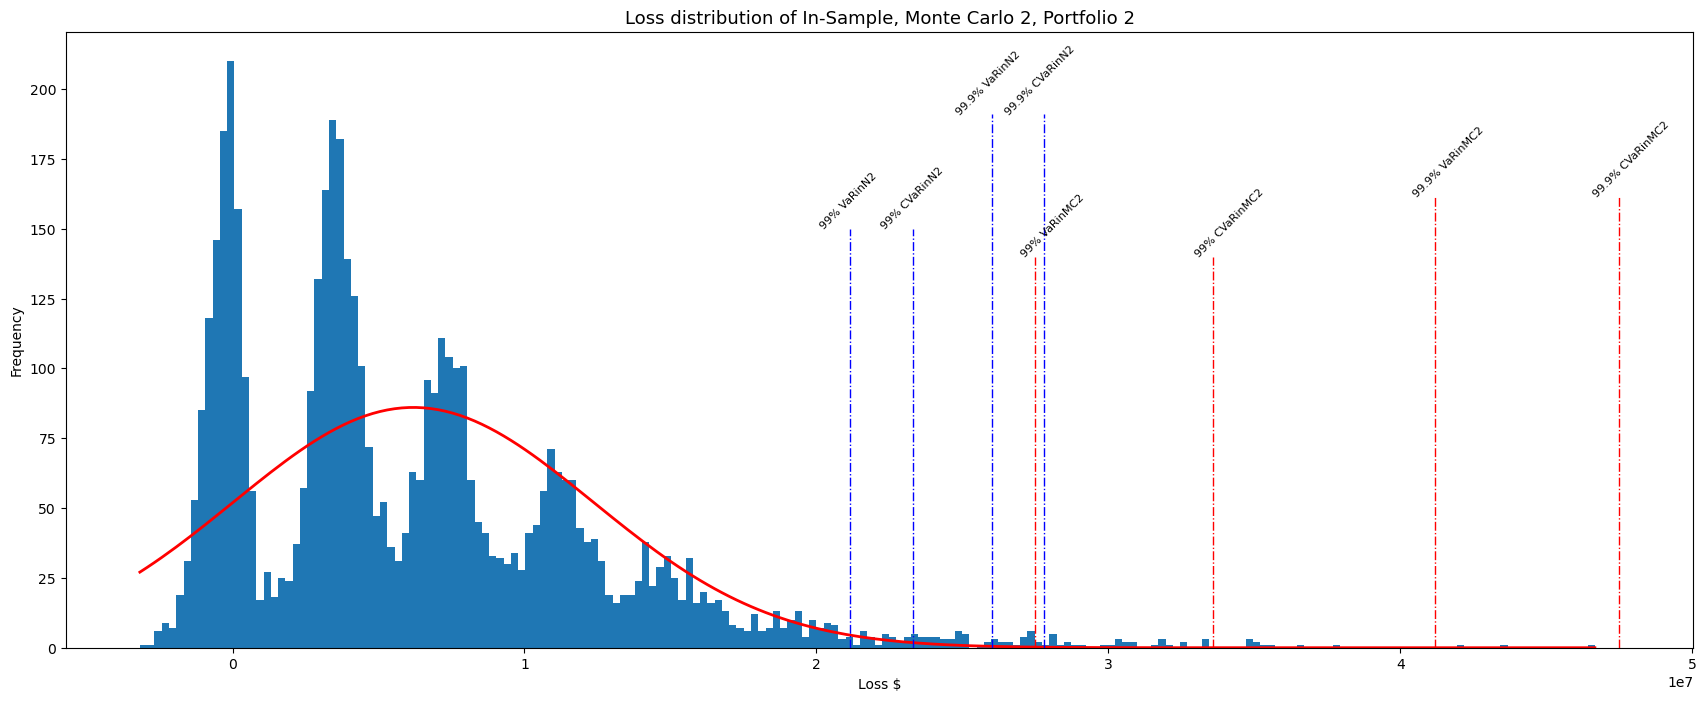

In [12]:
fig = plt.figure(figsize=(21,8))
frequencyCounts, binLocations, patches = plt.hist(Losses_inMC2 @ x0[1], 200)
# Plot the Normal curve 
sigma = np.std(np.dot(Losses_inMC2, x0[1]))
mu = np.mean(np.dot(Losses_inMC2, x0[1]))
normf = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (binLocations - mu)**2 / (2 * sigma**2))
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, linewidth=2, color='r')

# VaRinMC2
plt.plot([np.mean(VaRinMC2[1,0]),np.mean(VaRinMC2[1,0])], [0,max(frequencyCounts)/1.5], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(VaRinMC2[1,0]), max(frequencyCounts)/1.5, '99% VaRinMC2',fontsize=8, rotation=45)
plt.plot([np.mean(VaRinMC2[1,1]),np.mean(VaRinMC2[1,1])], [0,max(frequencyCounts)/1.3], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(VaRinMC2[1,1]), max(frequencyCounts)/1.3, '99.9% VaRinMC2',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinMC2[1,0]),np.mean(CVaRinMC2[1,0])], [0,max(frequencyCounts)/1.5], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(CVaRinMC2[1,0]), max(frequencyCounts)/1.5, '99% CVaRinMC2',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinMC2[1,1]),np.mean(CVaRinMC2[1,1])], [0,max(frequencyCounts)/1.3], linewidth=1, linestyle='-.', color = 'r')
plt.text(0.98 * np.mean(CVaRinMC2[1,1]), max(frequencyCounts)/1.3, '99.9% CVaRinMC2',fontsize=8, rotation=45)


# VaRinN2
plt.plot([np.mean(VaRinN2[1,0]),np.mean(VaRinN2[1,0])], [0,max(frequencyCounts)/1.4], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(VaRinN2[1,0]), max(frequencyCounts)/1.4, '99% VaRinN2',fontsize=8, rotation=45)
plt.plot([np.mean(VaRinN2[1,1]),np.mean(VaRinN2[1,1])], [0,max(frequencyCounts)/1.1], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(VaRinN2[1,1]), max(frequencyCounts)/1.1, '99.9% VaRinN2',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinN2[1,0]),np.mean(CVaRinN2[1,0])], [0,max(frequencyCounts)/1.4], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(CVaRinN2[1,0]), max(frequencyCounts)/1.4, '99% CVaRinN2',fontsize=8, rotation=45)
plt.plot([np.mean(CVaRinN2[1,1]),np.mean(CVaRinN2[1,1])], [0,max(frequencyCounts)/1.1], linewidth=1, linestyle='-.', color = 'b')
plt.text(0.95 * np.mean(CVaRinN2[1,1]), max(frequencyCounts)/1.1, '99.9% CVaRinN2',fontsize=8, rotation=45)


plt.xlabel('Loss $')
plt.ylabel('Frequency')
plt.title('Loss distribution of In-Sample, Monte Carlo 2, Portfolio 2', fontsize=13)
plt.show()

# Build tables for errors

## MC  approximations (16 rows), Sampling Error

In [13]:
# MC approximations, Sampling Error, VaR & CVaR
df_mc = pd.DataFrame(columns = ['In-Sample, SD', 'In-Sample, Mean', 'Out-Of-Sample', 'Sampling Error %'])

In [14]:
# Portfolio 1
# 99%
df_mc.loc['99% VaR, MC1, Portfolio 1'] = [np.std(VaRinMC1[0,0]), np.mean(VaRinMC1[0,0]), VaRout[0,0], (abs(np.mean(VaRinMC1[0,0])-VaRout[0,0])/VaRout[0,0])*100]
df_mc.loc['99% CVaR, MC1, Portfolio 1'] = [np.std(CVaRinMC1[0,0]), np.mean(CVaRinMC1[0,0]), CVaRout[0,0], (abs(np.mean(CVaRinMC1[0,0])-CVaRout[0,0])/VaRout[0,0])*100]
df_mc.loc['99% VaR, MC2, Portfolio 1'] = [np.std(VaRinMC2[0,0]), np.mean(VaRinMC2[0,0]), VaRout[0,0], (abs(np.mean(VaRinMC2[0,0])-VaRout[0,0])/VaRout[0,0])*100]
df_mc.loc['99% CVaR, MC2, Portfolio 1'] = [np.std(CVaRinMC2[0,0]), np.mean(CVaRinMC2[0,0]), CVaRout[0,0], (abs(np.mean(CVaRinMC2[0,0])-CVaRout[0,0])/VaRout[0,0])*100]

# 99.9%
df_mc.loc['99.9% VaR, MC1, Portfolio 1'] = [np.std(VaRinMC1[0,1]), np.mean(VaRinMC1[0,1]), VaRout[0,1], (abs(np.mean(VaRinMC1[0,1])-VaRout[0,1])/VaRout[0,1])*100]
df_mc.loc['99.9% CVaR, MC1, Portfolio 1'] = [np.std(CVaRinMC1[0,1]), np.mean(CVaRinMC1[0,1]), CVaRout[0,1], (abs(np.mean(CVaRinMC1[0,1])-CVaRout[0,1])/VaRout[0,1])*100]
df_mc.loc['99.9% VaR, MC2, Portfolio 1'] = [np.std(VaRinMC2[0,1]), np.mean(VaRinMC2[0,1]), VaRout[0,1], (abs(np.mean(VaRinMC2[0,1])-VaRout[0,1])/VaRout[0,1])*100]
df_mc.loc['99.9% CVaR, MC2, Portfolio 1'] = [np.std(CVaRinMC2[0,1]), np.mean(CVaRinMC2[0,1]), CVaRout[0,1], (abs(np.mean(CVaRinMC2[0,1])-CVaRout[0,1])/VaRout[0,1])*100]

In [15]:
# Portfolio 2
# 99%
df_mc.loc['99% VaR, MC1, Portfolio 2'] = [np.std(VaRinMC1[1,0]), np.mean(VaRinMC1[1,0]), VaRout[1,0], (abs(np.mean(VaRinMC1[1,0])-VaRout[1,0])/VaRout[1,0])*100]
df_mc.loc['99% CVaR, MC1, Portfolio 2'] = [np.std(CVaRinMC1[1,0]), np.mean(CVaRinMC1[1,0]), CVaRout[1,0], (abs(np.mean(CVaRinMC1[1,0])-CVaRout[1,0])/VaRout[1,0])*100]
df_mc.loc['99% VaR, MC2, Portfolio 2'] = [np.std(VaRinMC2[1,0]), np.mean(VaRinMC2[1,0]), VaRout[1,0], (abs(np.mean(VaRinMC2[1,0])-VaRout[1,0])/VaRout[1,0])*100]
df_mc.loc['99% CVaR, MC2, Portfolio 2'] = [np.std(CVaRinMC2[1,0]), np.mean(CVaRinMC2[1,0]), CVaRout[1,0], (abs(np.mean(CVaRinMC2[1,0])-CVaRout[1,0])/VaRout[1,0])*100]


# 99.9%
df_mc.loc['99.9% VaR, MC1, Portfolio 2'] = [np.std(VaRinMC1[1,1]), np.mean(VaRinMC1[1,1]), VaRout[1,1], (abs(np.mean(VaRinMC1[1,1])-VaRout[1,1])/VaRout[1,1])*100]
df_mc.loc['99.9% CVaR, MC1, Portfolio 2'] = [np.std(CVaRinMC1[1,1]), np.mean(CVaRinMC1[1,1]), CVaRout[1,1], (abs(np.mean(CVaRinMC1[1,1])-CVaRout[1,1])/VaRout[1,1])*100]
df_mc.loc['99.9% VaR, MC2, Portfolio 2'] = [np.std(VaRinMC2[1,1]), np.mean(VaRinMC2[1,1]), VaRout[1,1], (abs(np.mean(VaRinMC2[1,1])-VaRout[1,1])/VaRout[1,1])*100]
df_mc.loc['99.9% CVaR, MC2, Portfolio 2'] = [np.std(CVaRinMC2[1,1]), np.mean(CVaRinMC2[1,1]), CVaRout[1,1], (abs(np.mean(CVaRinMC2[1,1])-CVaRout[1,1])/VaRout[1,1])*100]

In [16]:
# Adjust format
df_mc['In-Sample, SD'] = df_mc['In-Sample, SD'].map('${:,.2f}'.format)
df_mc['In-Sample, Mean'] = df_mc['In-Sample, Mean'].map('${:,.2f}'.format)
df_mc['Out-Of-Sample'] = df_mc['Out-Of-Sample'].map('${:,.2f}'.format)
df_mc['Sampling Error %'] = df_mc['Sampling Error %'].map('{:,.2f}%'.format)

# MC approximations, Sampling Error, VaR & CVaR
df_mc

,"In-Sample, SD","In-Sample, Mean",Out-Of-Sample,Sampling Error %
"99% VaR, MC1, Portfolio 1","$1,467,947.15","$36,923,585.73","$37,224,279.60",0.81%
"99% CVaR, MC1, Portfolio 1","$2,079,799.44","$44,397,752.66","$44,700,209.98",0.81%
"99% VaR, MC2, Portfolio 1","$1,256,868.28","$37,335,232.57","$37,224,279.60",0.30%
"99% CVaR, MC2, Portfolio 1","$1,505,665.48","$44,874,637.61","$44,700,209.98",0.47%
"99.9% VaR, MC1, Portfolio 1","$3,711,772.26","$53,424,523.54","$54,009,147.56",1.08%
"99.9% CVaR, MC1, Portfolio 1","$6,087,784.79","$61,055,433.08","$60,975,475.86",0.15%
"99.9% VaR, MC2, Portfolio 1","$3,020,789.83","$53,934,526.62","$54,009,147.56",0.14%
"99.9% CVaR, MC2, Portfolio 1","$5,360,422.01","$61,696,819.04","$60,975,475.86",1.34%
"99% VaR, MC1, Portfolio 2","$1,387,457.64","$27,213,074.49","$27,480,823.68",0.97%
"99% CVaR, MC1, Portfolio 2","$2,192,969.58","$32,954,475.00","$33,424,646.72",1.71%


## Normal approximations (16 rows), Model Error

In [17]:
# Normal approximations, Model Error, VaR & CVaR
df_N = pd.DataFrame(columns = ['In-Sample, SD', 'In-Sample, Mean', 'Out-Of-Sample', 'Model Error %'])

In [18]:
# Portfolio 1
# 99%
df_N.loc['99% VaR, N1, Portfolio 1'] = [np.std(VaRinN1[0,0]), np.mean(VaRinN1[0,0]), VaRout[0,0], (abs(np.mean(VaRinN1[0,0])-VaRout[0,0])/VaRout[0,0])*100]
df_N.loc['99% CVaR, N1, Portfolio 1'] = [np.std(CVaRinN1[0,0]), np.mean(CVaRinN1[0,0]), CVaRout[0,0], (abs(np.mean(CVaRinN1[0,0])-CVaRout[0,0])/VaRout[0,0])*100]
df_N.loc['99% VaR, N2, Portfolio 1'] = [np.std(VaRinN2[0,0]),np.mean(VaRinN2[0,0]), VaRout[0,0], (abs(np.mean(VaRinN2[0,0])-VaRout[0,0])/VaRout[0,0])*100]
df_N.loc['99% CVaR, N2, Portfolio 1'] = [np.std(CVaRinN2[0,0]), np.mean(CVaRinN2[0,0]), CVaRout[0,0], (abs(np.mean(CVaRinN2[0,0])-CVaRout[0,0])/VaRout[0,0])*100]

# 99.9%
df_N.loc['99.9% VaR, N1, Portfolio 1'] = [np.std(VaRinN1[0,1]), np.mean(VaRinN1[0,1]), VaRout[0,1], (abs(np.mean(VaRinN1[0,1])-VaRout[0,1])/VaRout[0,1])*100]
df_N.loc['99.9% CVaR, N1, Portfolio 1'] = [np.std(CVaRinN1[0,1]), np.mean(CVaRinN1[0,1]), CVaRout[0,1], (abs(np.mean(CVaRinN1[0,1])-CVaRout[0,1])/VaRout[0,1])*100]
df_N.loc['99.9% VaR, N2, Portfolio 1'] = [np.std(VaRinN2[0,1]), np.mean(VaRinN2[0,1]), VaRout[0,1], (abs(np.mean(VaRinN2[0,1])-VaRout[0,1])/VaRout[0,1])*100]
df_N.loc['99.9% CVaR, N2, Portfolio 1'] = [np.std(CVaRinN2[0,1]), np.mean(CVaRinN2[0,1]), CVaRout[0,1], (abs(np.mean(CVaRinN2[0,1])-CVaRout[0,1])/VaRout[0,1])*100]



# Portfolio 2
# 99%
df_N.loc['99% VaR, N1, Portfolio 2'] = [np.std(VaRinN1[1,0]), np.mean(VaRinN1[1,0]), VaRout[1,0], (abs(np.mean(VaRinN1[1,0])-VaRout[1,0])/VaRout[1,0])*100]
df_N.loc['99% CVaR, N1, Portfolio 2'] = [np.std(CVaRinN1[1,0]), np.mean(CVaRinN1[1,0]), CVaRout[1,0], (abs(np.mean(CVaRinN1[1,0])-CVaRout[1,0])/VaRout[1,0])*100]
df_N.loc['99% VaR, N2, Portfolio 2'] = [np.std(VaRinN2[1,0]), np.mean(VaRinN2[1,0]), VaRout[1,0], (abs(np.mean(VaRinN2[1,0])-VaRout[1,0])/VaRout[1,0])*100]
df_N.loc['99% CVaR, N2, Portfolio 2'] = [np.std(CVaRinN2[1,0]), np.mean(CVaRinN2[1,0]), CVaRout[1,0], (abs(np.mean(CVaRinN2[1,0])-CVaRout[1,0])/VaRout[1,0])*100]

# 99.9%
df_N.loc['99.9% VaR, N1, Portfolio 2'] = [np.std(VaRinN1[1,1]), np.mean(VaRinN1[1,1]), VaRout[1,1], (abs(np.mean(VaRinN1[1,1])-VaRout[1,1])/VaRout[1,1])*100]
df_N.loc['99.9% CVaR, N1, Portfolio 2'] = [np.std(CVaRinN1[1,1]), np.mean(CVaRinN1[1,1]), CVaRout[1,1], (abs(np.mean(CVaRinN1[1,1])-CVaRout[1,1])/VaRout[1,1])*100]
df_N.loc['99.9% VaR, N2, Portfolio 2'] = [np.std(VaRinN2[1,1]), np.mean(VaRinN2[1,1]), VaRout[1,1], (abs(np.mean(VaRinN2[1,1])-VaRout[1,1])/VaRout[1,1])*100]
df_N.loc['99.9% CVaR, N2, Portfolio 2'] = [np.std(CVaRinN2[1,1]), np.mean(CVaRinN2[1,1]), CVaRout[1,1], (abs(np.mean(CVaRinN2[1,1])-CVaRout[1,1])/VaRout[1,1])*100]

In [19]:
# Adjust format
df_N['In-Sample, SD'] = df_N['In-Sample, SD'].map('${:,.2f}'.format)
df_N['In-Sample, Mean'] = df_N['In-Sample, Mean'].map('${:,.2f}'.format)
df_N['Out-Of-Sample'] = df_N['Out-Of-Sample'].map('${:,.2f}'.format)
df_N['Model Error %'] = df_N['Model Error %'].map('{:,.2f}%'.format)

# Normal approximations, Model Error, VaR & CVaR
df_N

,"In-Sample, SD","In-Sample, Mean",Out-Of-Sample,Model Error %
"99% VaR, N1, Portfolio 1","$824,600.03","$26,143,547.56","$37,224,279.60",29.77%
"99% CVaR, N1, Portfolio 1","$915,092.00","$29,025,723.51","$44,700,209.98",42.11%
"99% VaR, N2, Portfolio 1","$566,343.66","$26,284,755.06","$37,224,279.60",29.39%
"99% CVaR, N2, Portfolio 1","$632,171.08","$29,184,999.54","$44,700,209.98",41.68%
"99.9% VaR, N1, Portfolio 1","$1,028,792.86","$32,640,649.93","$54,009,147.56",39.56%
"99.9% CVaR, N1, Portfolio 1","$1,102,948.54","$34,995,421.42","$60,975,475.86",48.10%
"99.9% VaR, N2, Portfolio 1","$714,856.41","$32,822,588.15","$54,009,147.56",39.23%
"99.9% CVaR, N2, Portfolio 1","$768,771.73","$35,192,121.84","$60,975,475.86",47.74%
"99% VaR, N1, Portfolio 2","$649,651.14","$21,017,924.28","$27,480,823.68",23.52%
"99% CVaR, N1, Portfolio 2","$721,402.82","$23,171,942.45","$33,424,646.72",37.31%
